In [71]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import lines
from matplotlib.image import NonUniformImage
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [126]:
#imports all the important maps that we'll use throughout the notebook

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1)    #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2)    #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")                    #opens map header for frequency template
data = hdu[3].data                           #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])       #creates an array of template frequency
f = np.array([i[1] for i in data])           #creates an array of spdust2 spectrum
h = hp.read_map('mom0_-90_90_1024.hpx.fits') #reads map of HI column denisty
nh = hp.pixelfunc.ud_grade(h, 256)           #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')     #reads map of CNM fraction
f_CNM = hp.ud_grade(CNM, 256)                #degrades to NPIX = 256

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [248]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    ''' Calculate a specific intensity curve for a pixel at either a range or a specific value of nu
        
        Input:  A1: float, amplitude from primary map
                A2: float, amplitude from secondary map
                nu_p1: float, peak frequency from primary map
                nu_sd: array, template frequency
                f: array, template frequency 
                nu: array, range of frequencies over which to evaluate the function
        
        Return: array of shape [1,n]; values of specific intensity in MJy/sr for each of the n discrete values of nu
    '''
    nu_p0 = 30. 
    nu_p2 = 33.35 #sets frequency peak for all secondary pixels
    nu_01 = 22.8 #sets reference freq for primary pixels
    nu_02 = 41.0 #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1) #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2) #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f) #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f) #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f) #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f) #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1) #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2) #component from secondary
    m_K1 = I_1*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy #gets rid of units for plotting purposes

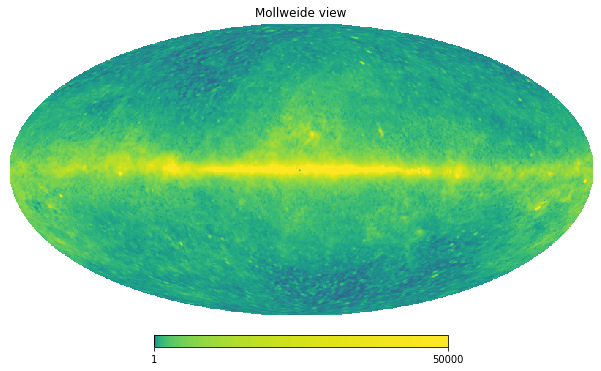

In [257]:
nu = np.linspace(1, 100, len(m))
I_map = I(m, n, nu_p, nu_sd, f, 30)

hp.mollview(I_map, min=1, max=5e4, norm='log')

b
A1: 38.35100555419922
A2: 7.175516605377197
nu_p1: 18.51020050048828
r
A1: 46.07896041870117
A2: 7.155386924743652
nu_p1: 16.59246253967285
g
A1: 21.569089889526367
A2: 4.054325103759766
nu_p1: 13.820138931274414


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

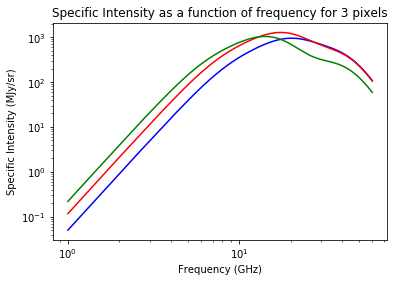

In [249]:
# This cell uses the I() function defined above to plot
# I_nu vs nu for a number, b, of pixels. It also prints 
# the primary and secondary amplitudes and primary peak
# frequency for each pixel.

b = 3 #number of pixels to be plotted
nu = np.linspace(1, 60, len(m)) #creates a range of values nu
pix = np.random.choice(range(len(m)), b) #randomly selects a pixel

for i in range(b):
    a1_i = m[pix[i]] #sets A1 for the ith random pixel
    a2_i = n[pix[i]] #sets A2 for the ith random pixel
    nup1_i = nu_p[pix[i]] #sets nu_p1 for the ith random pixel
    
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    
    #prints details on parameters of each curve
    print(color[i])
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))

plt.yscale('log')
plt.xscale('log')
plt.title('Specific Intensity as a function of frequency for ' + str(b) + ' pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

Text(0, 0.5, 'Template Frequency')

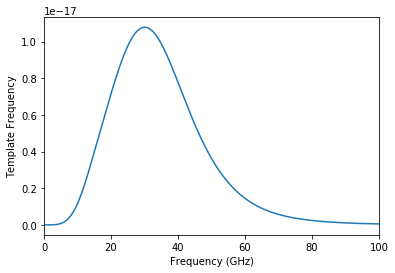

In [128]:
#This cell plots a curve of template frequency vs. frequency

plt.plot(nu_sd,f)
plt.xlabel('Frequency (GHz)')
plt.xlim(0,100)
plt.ylabel('Template Frequency')

In [129]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Pixel 0
330526 b
f_CNM: 1.2700658990070224
A1: 326.66754150390625
A2: 7.642416000366211
nu_p1: 20.941131591796875
Pixel 1
349244 r
f_CNM: -1.6374999999999998e+32
A1: 120.79593658447266
A2: 12.851724624633789
nu_p1: 19.725589752197266
Pixel 2
338556 g
f_CNM: -1.6374999999999998e+32
A1: 434.63079833984375
A2: 72.44532775878906
nu_p1: 18.3721923828125
Pixel 3
385665 c
f_CNM: -1.6374999999999998e+32
A1: 1131.5755615234375
A2: 186.04002380371094
nu_p1: 19.38799285888672


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

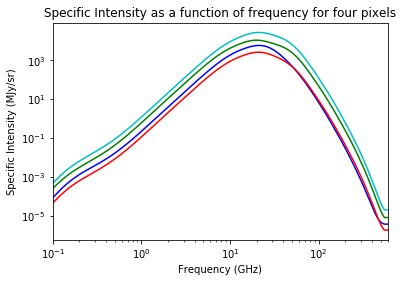

In [250]:
# This cell plots four random pixels and prints
# their f_CNM values in an attempt to see if there 
# is any relation between the two.

mask_ones = np.ones_like(CNM) #creates an array of 1s the size and shape of CNM
mask_zeros = np.where(CNM < 0, 0, mask_ones) #sets mask_one values to 0 where the f_CNM is unreasonable
mask_map = hp.pixelfunc.ud_grade(mask_zeros, 256) #degrades mask array to the right NSIDE
mask = np.where(mask_map < 1, 0, mask_map) #sets mask values to 0 where mask value is not 1
masked_fCNM = f_CNM[mask == 1] #masks fCNM map to just reasonable values

m_mask = m[mask == 1]
nu_p_mask = nu_p[mask == 1]
n_mask = n[mask == 1]

pix = []
for i in range(4):
    x = random.randint(330000, 400000)
    pix.append(x)

b = len(pix) #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m)) #creates a range of values nu

for i in range(b):
    a1_i = m_mask[pix[i]] #sets A1 for the ith random pixel
    a2_i = n_mask[pix[i]] #sets A2 for the ith random pixel
    nup1_i = nu_p_mask[pix[i]] #sets nu_p1 for the ith random pixel
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    print('Pixel ' + str(i))
    print(pix[i], color[i])
    #if f_CNM[pix[i]] >= 0: #sets it to only show up on the plot if the f_CNM is high enough
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    print('f_CNM: ' + str(masked_fCNM[pix[i]]*100))
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))
    #else: print('f_CNM is tiny')

plt.yscale('log')
plt.xscale('log')
plt.xlim(.1,600)
plt.title('Specific Intensity as a function of frequency for four pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

Text(0, 0.5, 'nu_p1')

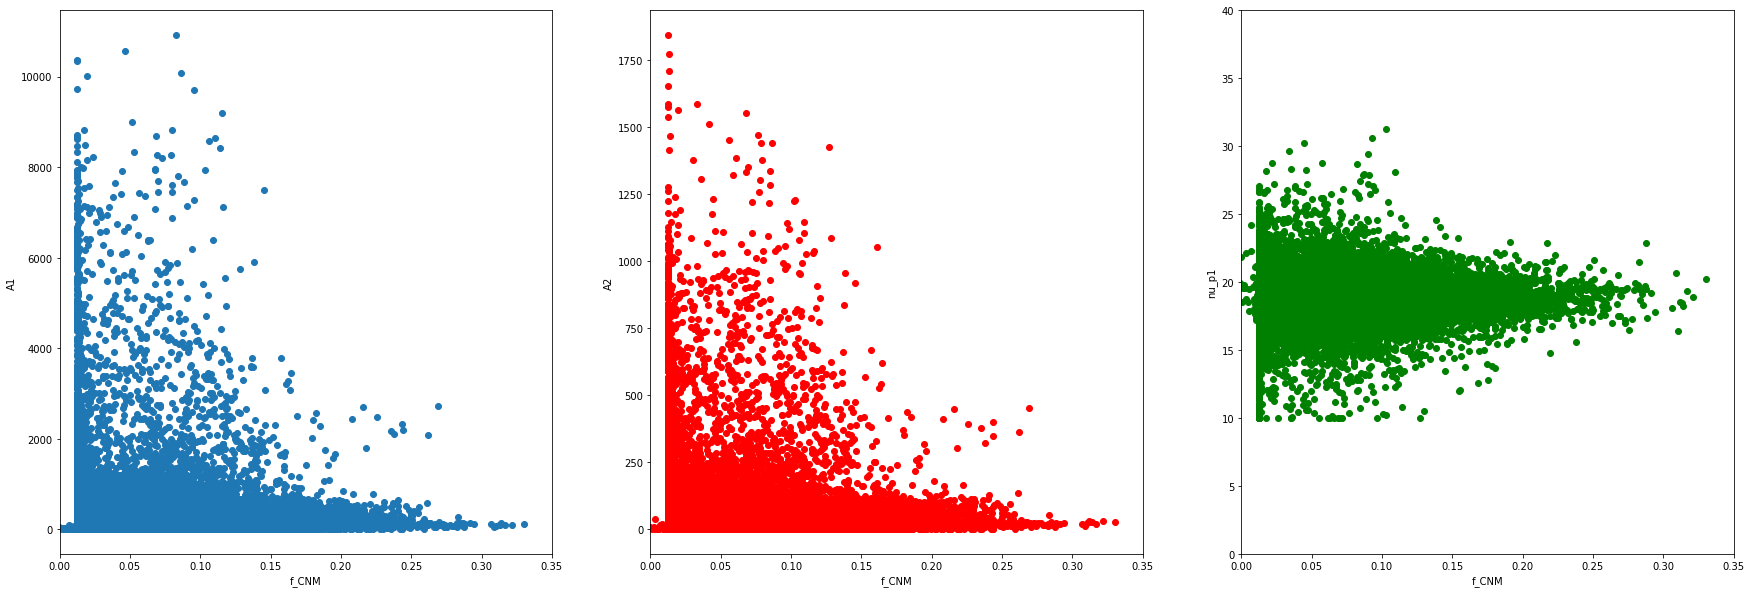

In [131]:
# Looks for trends in the primary and secondary amplitude vs. f_CNM (blue and red)
# and in peak frequency vs. f_CNM (green)

idx = np.random.choice(np.arange(len(m)), 100000, replace=False)
a1 = m[idx]
a2 = n[idx]
nup1 = nu_p[idx]
fCNM = f_CNM[idx]

fig, ax = plt.subplots(1,3, figsize=(30,10))

for i in range(3):
    ax[i].set_xlim(0, .35)

ax[0].scatter(fCNM, a1)
ax[0].set_xlabel("f_CNM")
ax[0].set_ylabel("A1")
plt.ylim(0, 12000)
ax[1].scatter(fCNM, a2, c='r')
plt.ylim(0, 2500)
ax[1].set_xlabel("f_CNM")
ax[1].set_ylabel("A2")
ax[2].scatter(fCNM, nup1, c='g')
plt.ylim(0, 40)
ax[2].set_xlabel("f_CNM")
ax[2].set_ylabel("nu_p1")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(-1, 2000)

In [132]:
def finite_fCNM(i,t):
    '''Input:
        i: map
        t: array of sample pixels
        
       Return:
        Array of the sample pixels of the map for which f_CNM is both finite and above .0128'''
    
    l = []
    for a in t:
        if np.isfinite(f_CNM[a]) == 1 and f_CNM[a] > 0.0128:
            l.append(i[a])
    return np.array(l)

In [137]:
a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)
N_HI = finite_fCNM(nh,t)

3.819784524975514
0.6432861848478977
31.9672131147541
7.3329263475419255


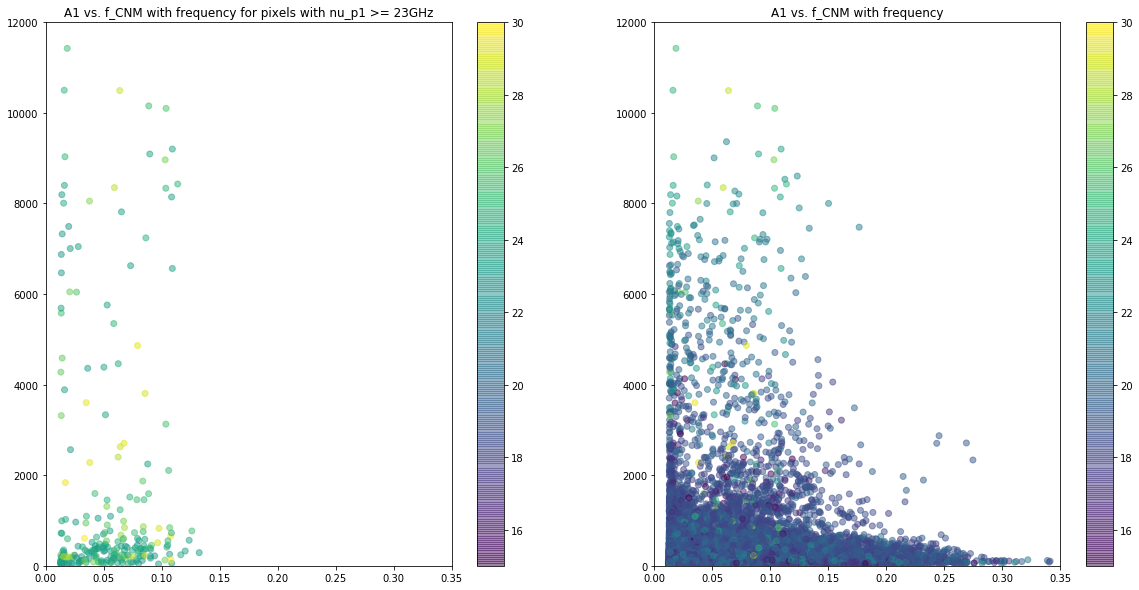

In [134]:
t = np.random.choice(np.arange(len(f_CNM)), 100000, replace=False)

lim = 23
a1_hi = []
fCNM_hi = []
nup1_hi = []
for x in range(len(fCNM)):
    if nup1[x] >= lim:
        a1_hi.append(a1[x])
        fCNM_hi.append(fCNM[x])
        nup1_hi.append(nup1[x])

hia_hinup = sum(1 if a1[i] >= 750 and nup1[i] >= lim else 0 for i in range(len(a1)))#number of points at high a1 with nup1 above limit
loa_hinup = sum(1 if a1[i] < 750 and nup1[i] >= lim else 0 for i in range(len(a1))) #number of points at low a1 with nup1 above limit
hia = sum(1 if a1[i] >= 750 else 0 for i in range(len(a1)))
loa = sum(1 if a1[i] < 750 else 0 for i in range(len(a1)))

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots points of nu_p1 greater than a certain limit
a = ax[0].scatter(fCNM_hi, a1_hi, alpha=.5, c=nup1_hi, vmin=15, vmax=30)
ax[0].set_ylim(0,12000)
ax[0].set_xlim(0,.35)
ax[0].set_title('A1 vs. f_CNM with frequency for pixels with nu_p1 >= ' + str(lim) + 'GHz')
fig.colorbar(a, ax=ax[0])

#plots all 100000 points
b = ax[1].scatter(fCNM, a1, alpha=.5, c=nup1, vmin=15, vmax=30)
ax[1].set_ylim(0,12000)
ax[1].set_xlim(0,.35)
ax[1].set_title('A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

print(100*hia_hinup/hia) #Percent of high A1 vals with hi nup1: 
print(100*loa_hinup/loa) #Percent of low A1 vals with hi nup1:
print(100*hia_hinup/(hia_hinup+loa_hinup)) #Percent of hi nup1 pixels with hi A1:
print(100*hia/(hia+loa)) #Percent of pixels with hi A1:

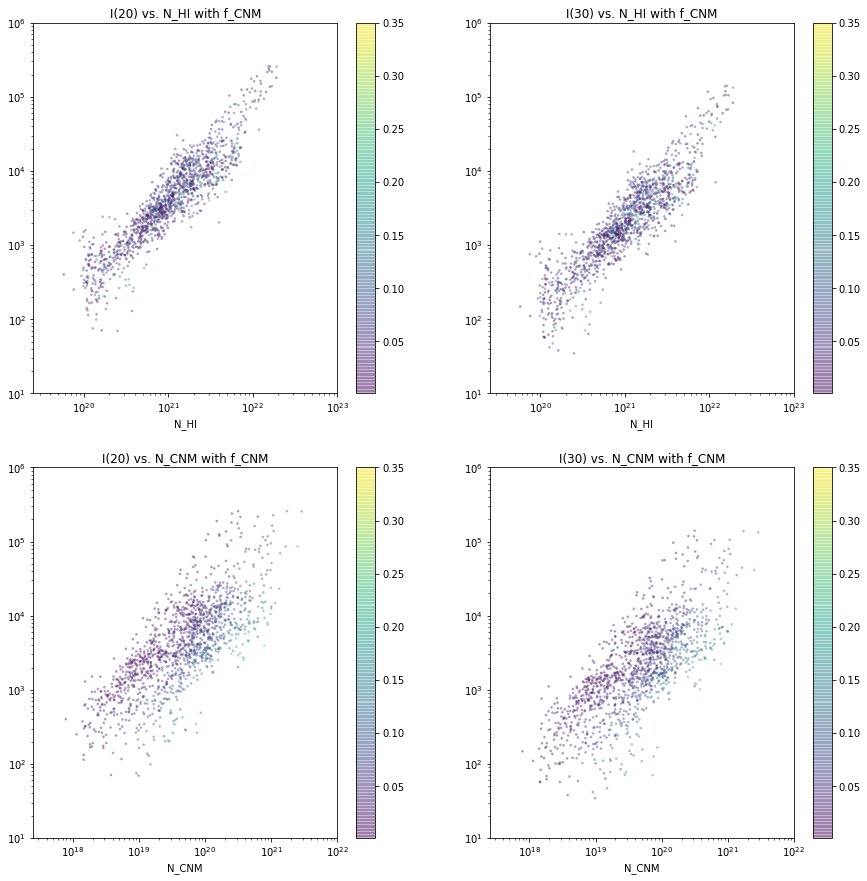

In [140]:
t = np.random.choice(np.arange(len(f_CNM)), 5000, replace=False)

N_CNM = fCNM * N_HI

I30 = []
I20 = []
for i in range(len(N_HI)):
    a_1 = a1[i]
    a_2 = a2[i]
    nu_p1 = nup1[i]
    nu30 = I(a_1, a_2, nu_p1, nu_sd, f, 30)
    nu20 = I(a_1, a_2, nu_p1, nu_sd, f, 20)
    I30.append(nu30)
    I20.append(nu20)

fig, ax = plt.subplots(2,2, figsize=(15, 15))

#plots all 100000 points
a = ax[0,0].scatter(N_HI, I20, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[0,0].set_xlim(2.5e19, 1e23)
ax[0,0].set_ylim(10, 1e6)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('N_HI')
ax[0,0].set_title('I(20) vs. N_HI with f_CNM')
fig.colorbar(a, ax=ax[0,0])

b = ax[0,1].scatter(N_HI, I30, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[0,1].set_xlim(2.5e19, 1e23)
ax[0,1].set_ylim(10, 1e6)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('N_HI')
ax[0,1].set_title('I(30) vs. N_HI with f_CNM')
fig.colorbar(b, ax=ax[0,1])

c = ax[1,0].scatter(N_CNM, I20, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[1,0].set_xlim(2.5e17, 1e22)
ax[1,0].set_ylim(10, 1e6)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('N_CNM')
ax[1,0].set_title('I(20) vs. N_CNM with f_CNM')
fig.colorbar(c, ax=ax[1,0])

d = ax[1,1].scatter(N_CNM, I30, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[1,1].set_xlim(2.5e17, 1e22)
ax[1,1].set_ylim(10, 1e6)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('N_CNM')
ax[1,1].set_title('I(30) vs. N_CNM with f_CNM')
fig.colorbar(d, ax=ax[1,1])

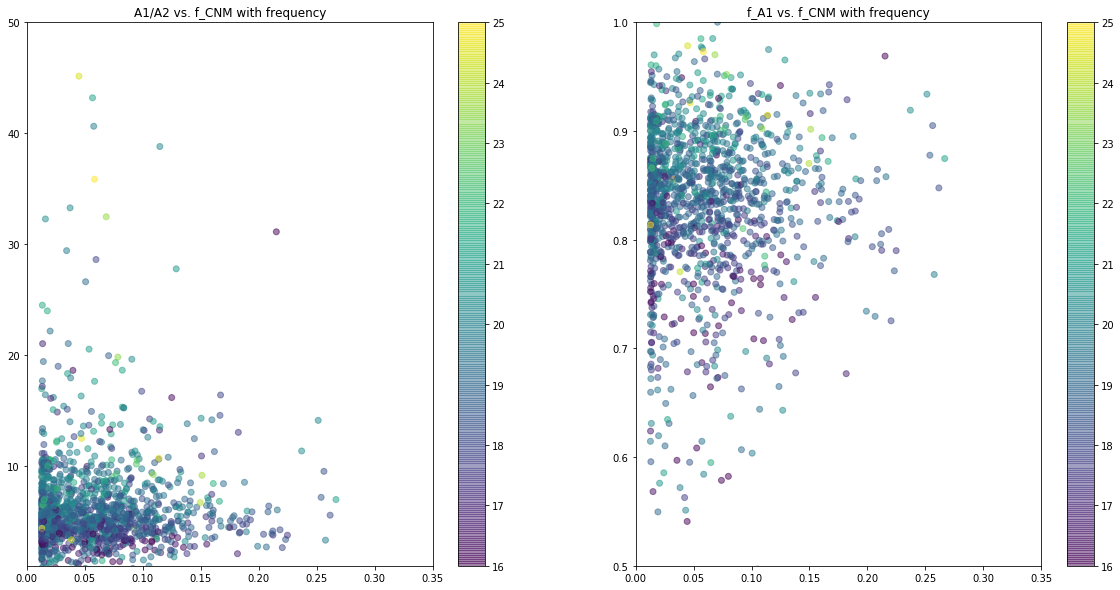

In [141]:
t = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)

r = a1/a2
fa1 = a1/(a1+a2)
fa2 = a2/(a1+a2)

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots ratio of two amplitued vs. f_CNM
a = ax[0].scatter(fCNM, r, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[0].set_ylim(1,50)
ax[0].set_xlim(0, .35)
ax[0].set_title('A1/A2 vs. f_CNM with frequency')
fig.colorbar(a, ax=ax[0])

#plots fraction of total amplitude included in primary map vs. f_CNM
b = ax[1].scatter(fCNM, fa1, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[1].set_ylim(.5,1)
ax[1].set_xlim(0,.35)
ax[1].set_title('f_A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

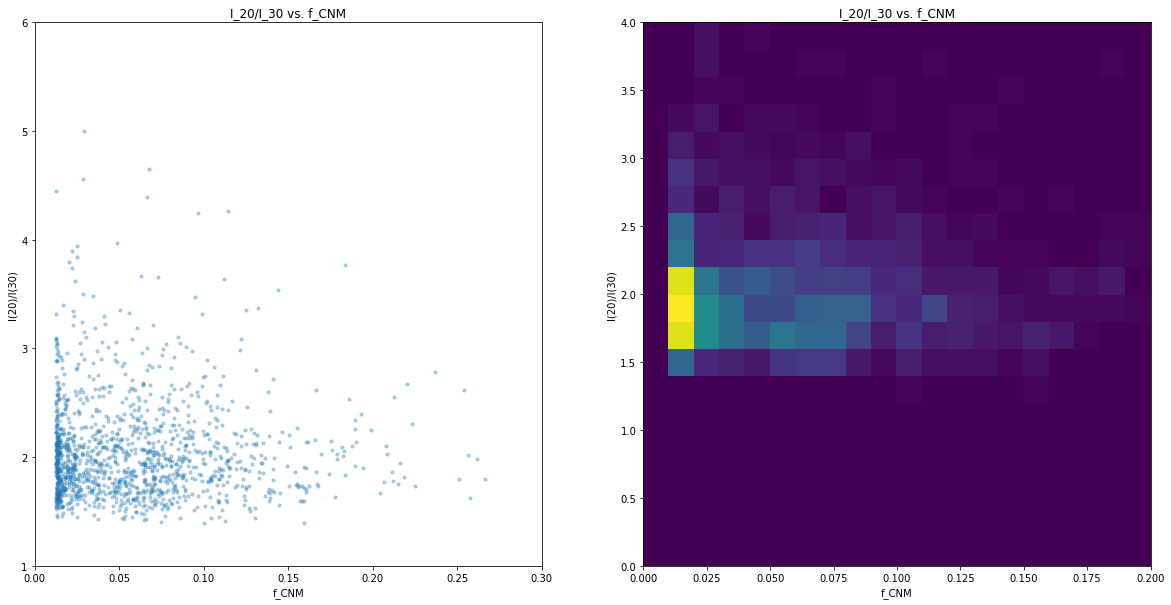

In [142]:
#ratio of I(20 GHz)/I(30 GHz) for various pixels plotted against f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)
b = len(a1) #number of pixels to be plotted

I_20 = []
I_30 = []
for i in range(b):
    a1_i = m[i]
    a2_i = n[i] 
    nup1_i = nu_p[i] 
    I_20.append(I(a1_i, a2_i, nup1_i, nu_sd, f, 20))
    I_30.append(I(a1_i, a2_i, nup1_i, nu_sd, f, 30))

I20 = np.array(I_20)
I30 = np.array(I_30)
y = I20/I30

fig, ax = plt.subplots(1,2, figsize=(20,10))

a = ax[0].scatter(fCNM, y, s=10, alpha=.3)
ax[0].set_ylim(1,6)
ax[0].set_xlim(0, .3)

b = ax[1].hist2d(fCNM, y, bins=20, range=[[0, .2], [0, 4]])

for i in range(2):
    ax[i].set_title('I_20/I_30 vs. f_CNM')
    ax[i].set_xlabel('f_CNM')
    ax[i].set_ylabel('I(20)/I(30)')

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
30
30
30
[19, 5]
f_CNM: 29.242469742894173
f_CNM: 1.2700235471129417
f_CNM: 30.613641999661922
f_CNM: 1.2718005222268403


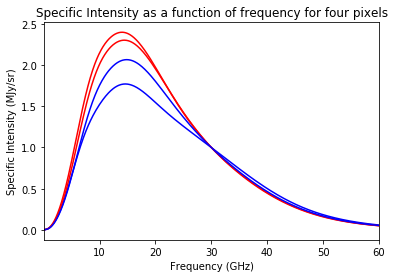

In [82]:
#Compares specific intensity curves for random points with low f_CNM to random points with high f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 300000, replace=False)

m_hi = []
n_hi = []
nu_p_hi = []
f_CNM_hi = []

m_lo = []
n_lo = []
nu_p_lo = []
f_CNM_lo = []

for i in idx:                        #creates bins of high and low f_CNM pixels, fills empty lists with their parameters 
    if 0 < f_CNM[i] < 0.02:
        m_lo.append(m[i])
        n_lo.append(n[i])
        nu_p_lo.append(nu_p[i])
        f_CNM_lo.append(f_CNM[i])
    elif 0.29 < f_CNM[i] < 0.31:
        m_hi.append(m[i])
        n_hi.append(n[i])
        nu_p_hi.append(nu_p[i])
        f_CNM_hi.append(f_CNM[i])

pix_lo = []
pix_hi = []
for i in range(2):                    #selects four random pixels, two each from high and low bins
    x = random.randint(0, len(m_lo))
    pix_lo.append(x-1)
    y = random.randint(0, len(m_hi))
    pix_hi.append(y-1)
    
b = len(pix_lo)                       #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m_lo)) #creates a range of values nu

for i in range(b):
    a1_lo = m_lo[pix_lo[i]] 
    a2_lo = n_lo[pix_lo[i]] 
    nup1_lo = nu_p_lo[pix_lo[i]] 
    I_nulo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, nu) 
    I_30lo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, 30)
    
    a1_hi = m_hi[pix_hi[i]] 
    a2_hi = n_hi[pix_hi[i]] 
    nup1_hi = nu_p_hi[pix_hi[i]]
    I_nuhi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, nu)
    I_30hi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, 30)
    
    plt.plot(nu, I_nuhi/I_30hi, 'r')
    plt.plot(nu, I_nulo/I_30lo, 'b')

    print('f_CNM: ' + str(f_CNM_hi[pix_hi[i]]*100))
    print('f_CNM: ' + str(f_CNM_lo[pix_lo[i]]*100))

    plt.xlim(.1,60)
    plt.title('Specific Intensity as a function of frequency for four pixels')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Specific Intensity (MJy/sr)')

In [83]:
def fCNM_bin(f_CNM, m, n, nu_p):
    
    idx = np.random.choice(np.arange(len(f_CNM)), len(f_CNM), replace=False)
    
    m_0, m_1, m_2, m_3, m_4, m_5 = [], [], [], [], [], []
    n_0, n_1, n_2, n_3, n_4, n_5 = [], [], [], [], [], []
    nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = [], [], [], [], [], []
    f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = [], [], [], [], [], []
    
    for x in idx: #sorts the pixels into bins based on fCNM
        if 0 < f_CNM[x] <= 0.06:
            m_0.append(m[x])
            n_0.append(n[x])
            nu_p0.append(nu_p[x])
        elif 0.06 < f_CNM[x] <= 0.12:
            m_1.append(m[x])
            n_1.append(n[x])
            nu_p1.append(nu_p[x])
        elif 0.12 < f_CNM[x] <= 0.18:
            m_2.append(m[x])
            n_2.append(n[x])
            nu_p2.append(nu_p[x])
        elif 0.18 < f_CNM[x] <= 0.24:
            m_3.append(m[x])
            n_3.append(n[x])
            nu_p3.append(nu_p[x])
        elif 0.24 < f_CNM[x] <= 0.30:
            m_4.append(m[x])
            n_4.append(n[x])
            nu_p4.append(nu_p[x])
        elif 0.30 < f_CNM[x] <= 0.36:
            m_5.append(m[x])
            n_5.append(n[x])
            nu_p5.append(nu_p[x])
    return

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

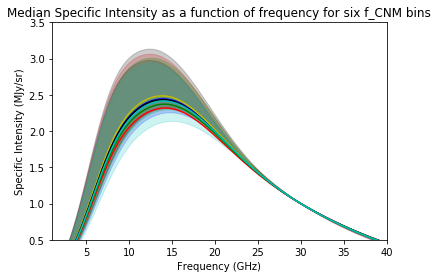

In [86]:
idx = np.random.choice(np.arange(len(f_CNM)), len(f_CNM), replace=False)

m_0, m_1, m_2, m_3, m_4, m_5 = [], [], [], [], [], []
n_0, n_1, n_2, n_3, n_4, n_5 = [], [], [], [], [], []
nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = [], [], [], [], [], []
f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = [], [], [], [], [], []
    
for x in idx: #sorts the pixels into bins based on fCNM
    if 0 < f_CNM[x] <= 0.06:
        m_0.append(m[x])
        n_0.append(n[x])
        nu_p0.append(nu_p[x])
    elif 0.06 < f_CNM[x] <= 0.12:
        m_1.append(m[x])
        n_1.append(n[x])
        nu_p1.append(nu_p[x])
    elif 0.12 < f_CNM[x] <= 0.18:
        m_2.append(m[x])
        n_2.append(n[x])
        nu_p2.append(nu_p[x])
    elif 0.18 < f_CNM[x] <= 0.24:
        m_3.append(m[x])
        n_3.append(n[x])
        nu_p3.append(nu_p[x])
    elif 0.24 < f_CNM[x] <= 0.30:
        m_4.append(m[x])
        n_4.append(n[x])
        nu_p4.append(nu_p[x])
    elif 0.30 < f_CNM[x] <= 0.36:
        m_5.append(m[x])
        n_5.append(n[x])
        nu_p5.append(nu_p[x])

# creates arrays which store the median values of each of the parameters for each of the bins
m_m = np.array([np.median(m_0), np.median(m_1), np.median(m_2), np.median(m_3), np.median(m_4), np.median(m_5)])
n_m = np.array([np.median(n_0), np.median(n_1), np.median(n_2), np.median(n_3), np.median(n_4), np.median(n_5)])
nu_pm = np.array([np.median(nu_p0), np.median(nu_p1), np.median(nu_p2), np.median(nu_p3), np.median(nu_p4), np.median(nu_p5)])

# creates arrays which store the standard deviations of each of the parameters for each of the bins
m_std = np.array([np.std(m_0), np.std(m_1), np.std(m_2), np.std(m_3), np.std(m_4), np.std(m_5)])
n_std = np.array([np.std(n_0), np.std(n_1), np.std(n_2), np.std(n_3), np.std(n_4), np.std(n_5)])
nu_pstd = np.array([np.std(nu_p0), np.std(nu_p1), np.std(nu_p2), np.std(nu_p3), np.std(nu_p4), np.std(nu_p5)])

nu = np.linspace(1, 100, len(m_0)) #creates a range of values nu

I_m = []
I_pos = []
I_neg = []
for i in range(6):
    I_nu = I(m_m[i], n_m[i], nu_pm[i], nu_sd, f, nu) 
    I_30 = I(m_m[i], n_m[i], nu_pm[i], nu_sd, f, 30)
    I_m.append(I_nu/I_30)
    
    a1std = m_m + m_std
    a2std = n_m + n_std
    nup1std = nu_pm + nu_pstd
    
    a1neg = m_m - m_std
    a2neg = n_m - n_std
    nup1neg = nu_pm - nu_pstd

    I_posstd = I(a1std[i], a2std[i], nup1std[i], nu_sd, f, nu)
    I_30posstd = I(a1std[i], a2std[i], nup1std[i], nu_sd, f, 30)
    I_pos.append(I_posstd/I_30posstd)
    
    I_negstd = I(a1neg[i], a2neg[i], nup1neg[i], nu_sd, f, nu)
    I_30negstd = I(a1neg[i], a2neg[i], nup1neg[i], nu_sd, f, 30)
    I_neg.append(I_negstd/I_30negstd)

plt.plot(nu, I_m[0], 'r')
plt.fill_between(nu, I_pos[0], I_neg[0], color='r', alpha = .2)
plt.plot(nu, I_m[1], 'b')
plt.fill_between(nu, I_pos[1], I_neg[1], color='b', alpha = .2)
plt.plot(nu, I_m[2], 'y')
plt.fill_between(nu, I_pos[2], I_neg[2], color='y', alpha = .2)
plt.plot(nu, I_m[3], 'k')
plt.fill_between(nu, I_pos[3], I_neg[3], color='k', alpha = .2)
plt.plot(nu, I_m[4], 'g')
plt.fill_between(nu, I_pos[4], I_neg[4], color='g', alpha = .2)
plt.plot(nu, I_m[5], 'c')
plt.fill_between(nu, I_pos[5], I_neg[5], color='c', alpha = .2)

#plt.yscale('log')
#plt.xscale('log')
plt.xlim(1,40)
plt.ylim(0.5,3.5)
plt.title('Median Specific Intensity as a function of frequency for six f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

In [242]:
def I_bins(m, n, nu_p):
    ''' Input:  m: array, map of primary component
            n: array, map of secondary component
            nu_p: array, map of peak frequency for primary component
           
    Return: I_norm: array representing normalized median specific intensity
            std: array, standard deviation
            nu: array, frequency values for pixels involved'''
    b = np.array(range(len(m)))
    nu = np.linspace(1, 100, 100)
    
    I_pix = np.empty((1,100))
    I_30 = np.empty((1,100))
    for i in b:
        a1 = m[i]
        a2 = n[i]
        nup = nu_p[i]
        
        Ii = np.array(I(a1, a2, nup, nu_sd, f, nu))
        I30 = np.array(I(a1, a2, nup, nu_sd, f, 30))
        Ii_norm = Ii / I30
        
        I_pix = np.vstack((I_pix, Ii_norm)) #makes ix100 array showing I; each row is one of n pixels, columns are distinct values of nu 
        I_30 = np.vstack((I_30, np.full((1,100), I30)))
    
    I_median = np.median(I_pix, axis=0) #takes median of the columns of our array representing I    
    I_normed = I_pix/I_30
    std = np.std(I_pix, axis=0)
    
    return I_median, std*(1/4), nu

In [181]:
#def psi(x, mu, sig):
#    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/np.sqrt(2. * np.pi * mu**2)
#
#def gaussian(x, mu, sig, a):
#    PSI = integrate.quad(lambda t: psi(t, 15., 7.), -np.inf, a*np.max(x))
#    return 2*psi(x, mu, sig)*PSI[0]

42587
6325
976
123


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

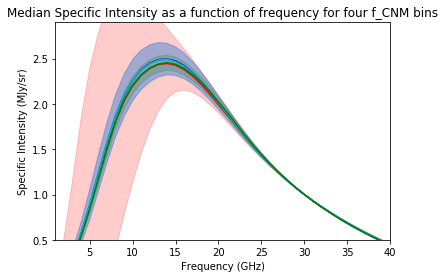

In [247]:
idx = np.random.choice(np.arange(len(f_CNM)), 100000, replace=False) #picks a set of pixels from the length of f_CNM

m_0, m_1, m_2, m_3, m_4, m_5 = ([] for i in range(6)) #creates 6 empty bins for m
n_0, n_1, n_2, n_3, n_4, n_5 = ([] for i in range(6)) #creates 6 empty bins for n
nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = ([] for i in range(6)) #creates 6 empty bins for nu_p
f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = ([] for i in range(6)) #creates 6 empty bins for f_CNM
    
for x in idx: #sorts the pixels into bins based on fCNM
    if 0 < f_CNM[x] <= 0.08:
        m_0.append(m[x])
        n_0.append(n[x])
        nu_p0.append(nu_p[x])
    elif 0.08 < f_CNM[x] <= 0.16:
        m_1.append(m[x])
        n_1.append(n[x])
        nu_p1.append(nu_p[x])
    elif 0.16 < f_CNM[x] <= 0.24:
        m_2.append(m[x])
        n_2.append(n[x])
        nu_p2.append(nu_p[x])
    elif 0.24 < f_CNM[x] <= 0.32:
        m_3.append(m[x])
        n_3.append(n[x])
        nu_p3.append(nu_p[x])
    #elif 0.20 < f_CNM[x] <= 0.25:
        #m_4.append(m[x])
        #n_4.append(n[x])
        #nu_p4.append(nu_p[x])
    #elif 0.25 < f_CNM[x] <= 0.30:
        #m_5.append(m[x])
        #n_5.append(n[x])
        #nu_p5.append(nu_p[x])

print(len(m_0))
print(len(m_1))
print(len(m_2))
print(len(m_3))
I0, std0, nu0 = I_bins(m_0, n_0, nu_p0)
pos0 = I0 + std0
neg0 = I0 - std0
I1, std1, nu1 = I_bins(m_1, n_1, nu_p1)
pos1 = I1 + std1
neg1 = I1 - std1
I2, std2, nu2 = I_bins(m_2, n_2, nu_p2)
pos2 = I2 + std2
neg2 = I2 - std2
I3, std3, nu3 = I_bins(m_3, n_3, nu_p3)
pos3 = I3 + std3
neg3 = I3 - std3
#I4, std4, nu4 = I_bins(m_4, n_4, nu_p4)
#pos4 = Im4 + std4
#neg4 = Im4 - std4
#I5, std5, nu5 = I_bins(m_5, n_5, nu_p5)
#pos5 = Im5 + std5
#neg5 = Im5 - std5

plt.plot(nu0, I0, 'r')
plt.fill_between(nu0, pos0, neg0, color='r', alpha = .2)
plt.plot(nu1, I1, 'b')
plt.fill_between(nu1, pos1, neg1, color='b', alpha = .2)
plt.plot(nu2, I2, 'c')
plt.fill_between(nu2, pos2, neg2, color='c', alpha = .2)
plt.plot(nu3, I3, 'g')
plt.fill_between(nu3, pos3, neg3, color='g', alpha = .2)

#Im0, Im0_cov = scipy.optimize.curve_fit(gaussian, nu0, I0, p0=[15,7,1])
#plt.plot(nu5, gaussian(nu5, Im5[0], Im5[1], Im5[2]), 'c')
#plt.fill_between(nu5, pos5, neg5, color='c', alpha = .2)

plt.xlim(1,40)
plt.ylim(0.5,2.9)
plt.title('Median Specific Intensity as a function of frequency for four f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')